# League Of Legend – Winning Prediction
- Author: Shawn Jung 
- Last Update: 7/3/2020 <br>
I had a chance to read the incredible book, ‘Bayesian Statistics The Fun Way,’ during the Corona lockdown. I was amazed by the process of calculating the posterior probability based on the prior and newly acquired information and repeating this process by putting the posterior as the prior input of the next step. It resembles what we would normally do when watching sports games on TV or eSports streaming on Twitch. We adjust the winning probability of the team as they hunted a dragon or getting killed by opponents. For detailed explanation, visit this blog post <BR>
https://shawnjung.blog/2020/07/03/league-of-legend-winning-prediction/

### Loading basic libraries

In [2]:
# pandas and numpy 
import pandas as pd  
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 

# metrics and dataset prepration 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

# loading classifier libraries 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
 
# For future serving
import joblib 
#from scipy.special import logsumexp

# Plotly Viz
import plotly.graph_objects as go 


### Let's get the dataframe
League of Legends is a multiplayer online battle game developed by Riot Games, which is a de-facto national sport in South Korea(just kidding but seriously in a way). There are multiple regional leagues around the globe competing with the world championship. Each game is a battle in the arena between two teams, Blue and Red, and a gamer is conducting a role within a team. So, the game result can be a dichotomous classification. And each game is full of exciting sub-events – placing of stealth wards, killing elite monsters, gaining Gold/Exp, and which team made the first kill. These are useful candidate features for continuous outcome prediction with Bayesian thinking. <BR>
I could get the diamond ranking game data from Kaggle. The dataset includes features for the first 10 minutes of each gameplay and the result. I was intrigued by predicting an outcome with the prelude of a game. The readers can get different data by directly using an API provided by Riot Games. <BR>
https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min 

In [3]:
pd.set_option('display.max_columns', None)

filepath = 'data/high_diamond_ranked_10min.csv'
df = pd.read_csv(filepath)
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [4]:
# It seems that there is no missing data
df.isnull().sum().any()

np.False_

In [5]:
# Win and Lose are balanced. What a pretty and neat dataset! 
df.groupby(by='blueWins').size()

blueWins
0    4949
1    4930
dtype: int64

### Feature Engineering 
* blueKills, redKills – The kills made by each team. A direct metric of how good the team is
* blueFirstBlood, redFirstBlood – Which team made the first kill. Yes, we gotta start on the right foot!
* blueDeath, redDeath – Just the flipped variables of the previous ones  
* blueAssits, redAssits – Attacks from players of each team, which did not lead to final dealing. In a way, these features are representing the team collaboration
* blueAvgLevel, redAvgLevel – Average level of champions per each team
* blueExp, redExp, blueGold, redGold – Experience stat and Gold gained by each team.  
* blueDragons, blueHeralds, blueEliteMonsters, redDragons, redHeralds, redEliteMonsters – How many Dragons and Heralds were killed by a team. Each count can be a good predictor of wins since they are powerful, elite monsters in games
* blueTotalMinionsKilled, blueJungleMinionsKilled, redTotalMinionsKilled, redJungleMinionsKilled – kill count of miscellaneous monsters
* blueWardsPlaced, blueWardsDestroyed, redWardsPlaced, redWardsDestroyed – Wards are one of the deployable units to get different benefits. So the number of placements or destructions are representing active or dominant gameplay in the first 10 minutes
* blueTowersDestroyed, redTowersDestroyed – The number of opponent turrets destroyed by each team. Also a useful index of the aggressive unfolding of a game
* Comparative or aggregational features – Variables such as the difference of Gold amount between teams(redGoldDiff) or how many monsters were killed per minute(blueCSPerMin)

When checking out the histogram of each feature, I found that many quantitative variables show a moderate bell-shaped curve. So, going with Gaussian Naïve Bayesian is not a bad idea.

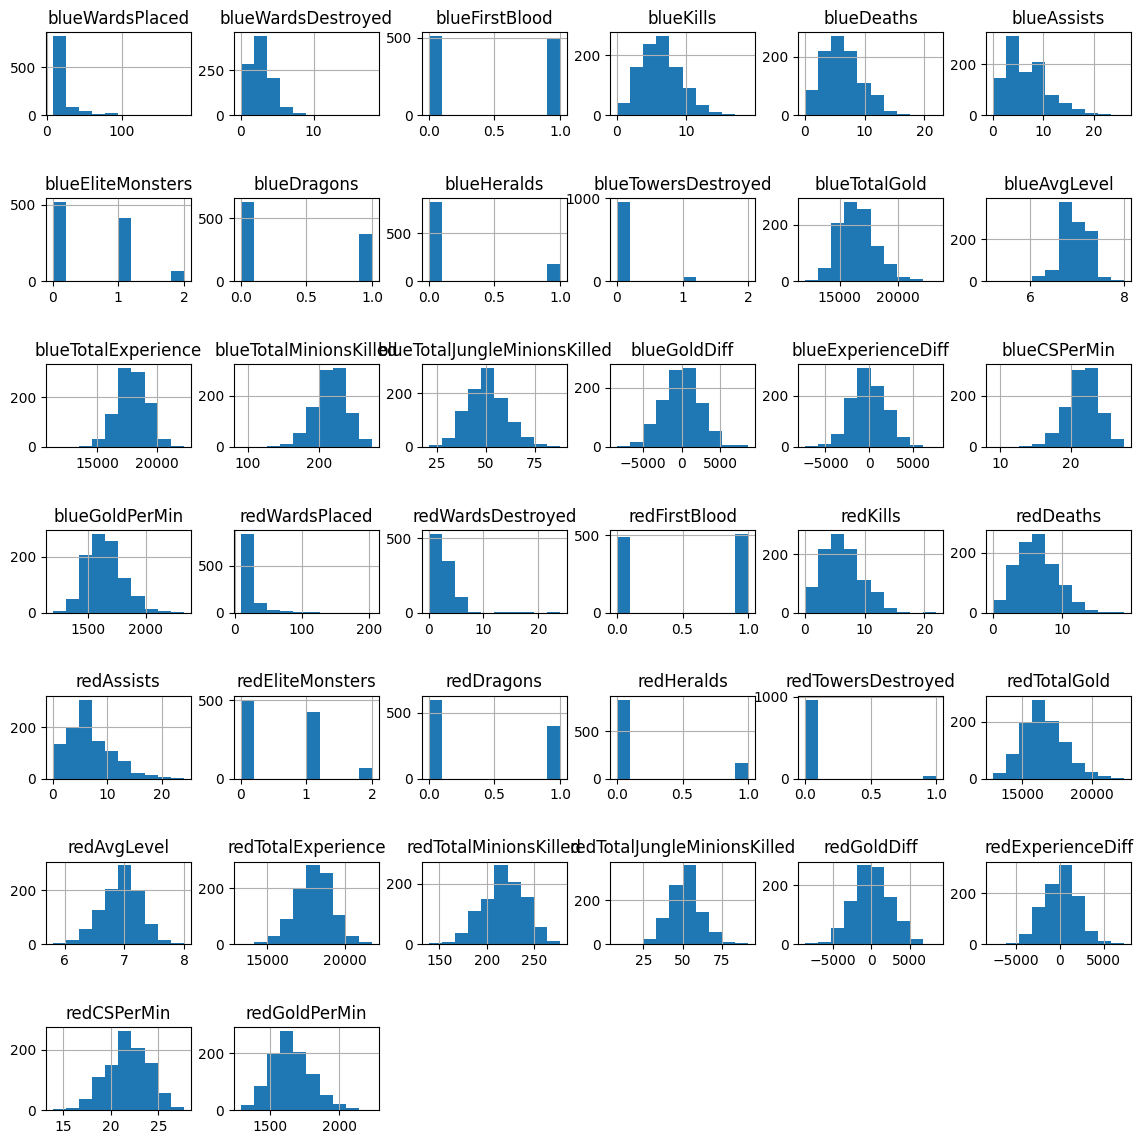

In [6]:
df.iloc[:,2:].sample(1000).hist(figsize=(14,14))
plt.rcParams['axes.titlesize'] = 5
plt.subplots_adjust(hspace=1)
plt.show()


I might as well apply binning for these skewed features. For instance, the Wards grants sights on the game map, and I see weirdly high outliers while 75% quantile ward numbers are 20. Considering median value 16 and the game behavior, it makes sense to transform such variables into ordinal values

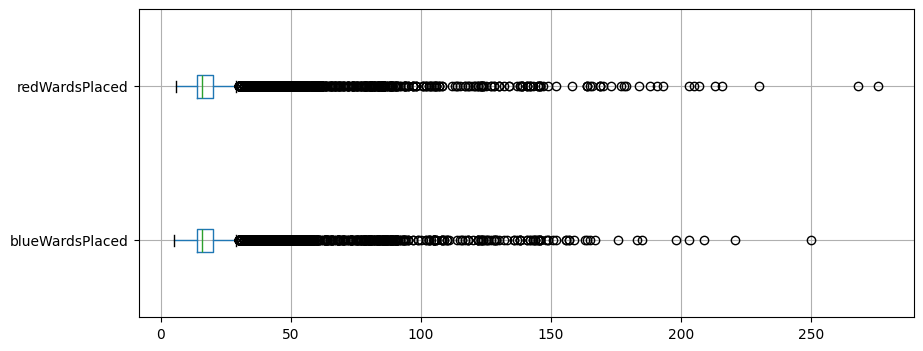

In [7]:
df[['blueWardsPlaced', 'redWardsPlaced']].boxplot(figsize=(10,4), vert=False)
plt.rcParams['axes.titlesize'] = 15
plt.show()

In [8]:
df[['blueWardsPlaced', 'redWardsPlaced', 'blueWardsDestroyed', 'redWardsDestroyed']].describe()

,blueWardsPlaced,redWardsPlaced,blueWardsDestroyed,redWardsDestroyed
count,9879.000000,9879.000000,9879.000000,9879.000000
mean,22.288288,22.367952,2.824881,2.723150
std,18.019177,18.457427,2.174998,2.138356
min,5.000000,6.000000,0.000000,0.000000
25%,14.000000,14.000000,1.000000,1.000000
50%,16.000000,16.000000,3.000000,2.000000
75%,20.000000,20.000000,4.000000,4.000000
max,250.000000,276.000000,27.000000,24.000000


In [9]:
# quantizing four skewed variables 
df['blueWardsPlaced'] = pd.cut(df['blueWardsPlaced'], bins=[-float('inf'), 14,16,20, float('inf')], labels=False)
df['redWardsPlaced'] = pd.cut(df['redWardsPlaced'], bins=[-float('inf'), 14,16,20, float('inf')], labels=False)
df['blueWardsDestroyed'] = pd.cut(df['blueWardsDestroyed'], bins=[-float('inf'), 1,3,4, float('inf')], labels=False)
df['redWardsDestroyed'] = pd.cut(df['redWardsDestroyed'], bins=[-float('inf'), 1,3,4, float('inf')], labels=False)


In [10]:
# now they are balanced, categorical variables 
df.groupby(by='blueWardsPlaced').size()

blueWardsPlaced
0    2508
1    2472
2    2590
3    2309
dtype: int64

As we can see from the above, some variables are direct linear combinations of other variables. For instance, the number of Kills by Blue team is technically the same as the number of Deaths by the Red team. And it is natural that golds, kills, experience, or level would be correlated as winning teams would show gain higher points. Take a look at a higher correlation between ‘redTotalGold’ and ‘blueDeaths(kills by Red)’ or ‘redGoldPerMin’ and ‘blueDeaths’ from the correlation plot. Those squares glow in crimson color (Pearson’s R > 0.85)

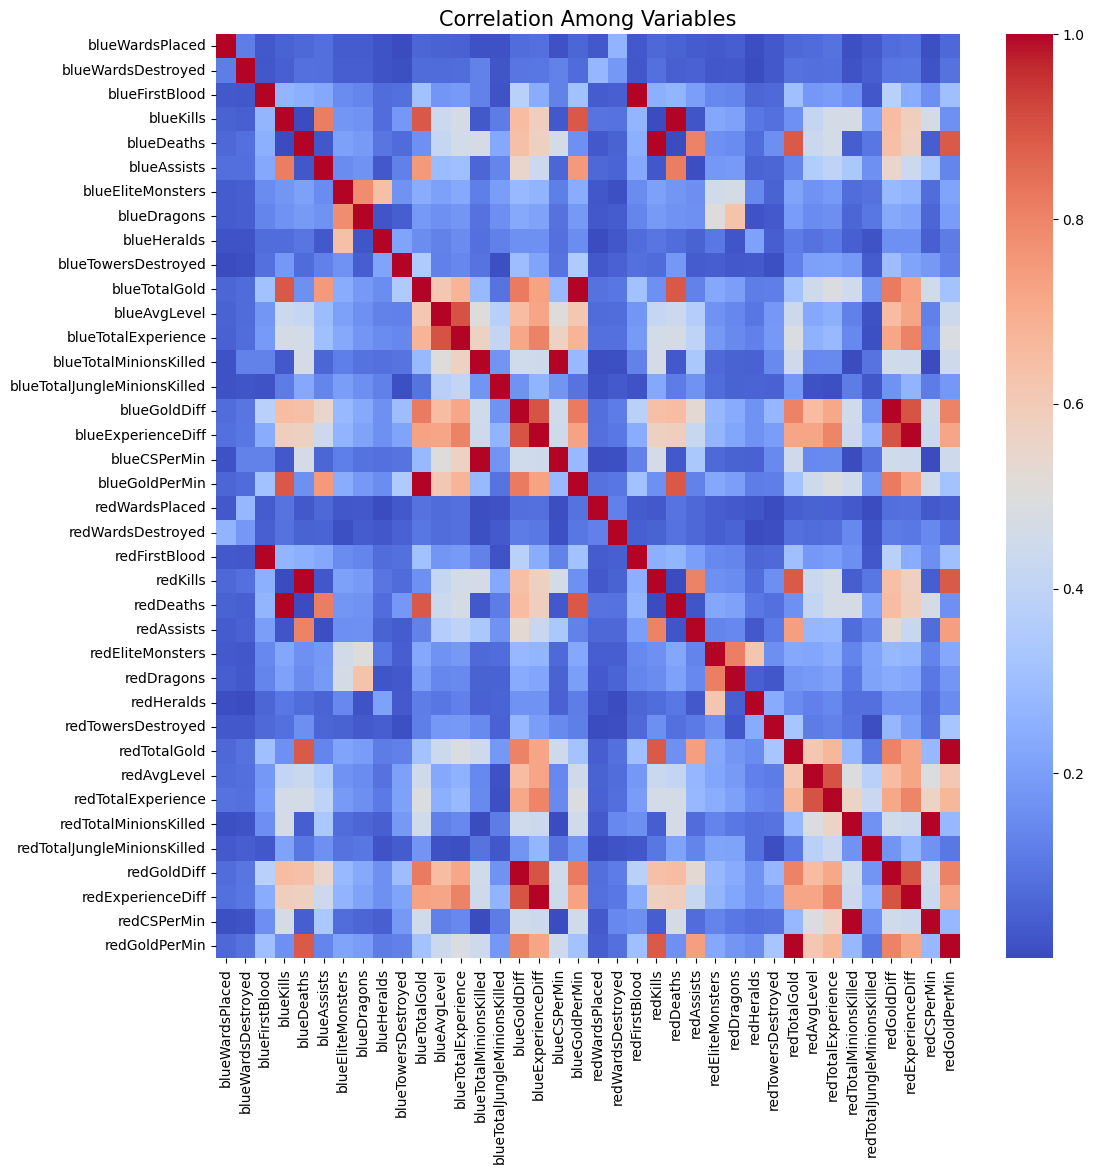

In [11]:
corr = np.abs(df.iloc[:,2:].corr())
fig, ax = plt.subplots(figsize=(12,12))
plt.rcParams['axes.titlesize'] = 15
sns.heatmap(corr, cmap='coolwarm', ax=ax)
plt.title('Correlation Among Variables')
plt.show()

In [12]:
corr = np.abs(df.iloc[:,2:].corr())
corr = corr.stack().reset_index()
corr.columns = ['feature_1', 'feature_2', 'correlation(abs)']
# remove diagonal tuples (correlation to a self)
corr = corr[corr['feature_1'] != corr['feature_2']]
# remove duplicated lower left tuples under the diagonal line
# refer to https://stackoverflow.com/questions/48395350/how-to-remove-duplicates-from-correlation-in-pandas 
corr['ordered_cols'] = corr.apply(lambda x: '-'.join(sorted([x['feature_1'], x['feature_2']])), axis=1)
corr = corr.drop_duplicates(['ordered_cols'])
corr.drop(['ordered_cols'], axis=1, inplace=True)

In [13]:
high_corr = corr[corr['correlation(abs)'] >= 0.7].sort_values(by='correlation(abs)', ascending=False)
pd.set_option('display.max_rows', None)

The variable tuples that showed correlation value 1.0 seems to be consisted of the same variables or flipped couples. For instance, the 'blueKills', the number of kills by Blue team is essentially the 'redDeaths', the number of death counts by Red team. So we can remove such duplicated variables from the feature list 

In [14]:
high_corr[high_corr['correlation(abs)'] == 1]

,feature_1,feature_2,correlation(abs)
643,blueExperienceDiff,redExperienceDiff,1.0
604,blueGoldDiff,redGoldDiff,1.0
137,blueKills,redDeaths,1.0
174,blueDeaths,redKills,1.0


In [15]:
# append features to remove later 
features_to_remove = list()
features_to_remove.extend(['redFirstBlood', 'redExperienceDiff', 'redGoldDiff', 'redDeaths', 'redKills'])

From the remaining list, we will remove variables from apparant linear combination of other variables. For instance, the gold amount difference between two teams('redGoldDiff', 'blueGoldDiff') can be removed. The same goes with 'Elite Monster Kills' which is a sum of 'Harolds Kill' and 'Dragons Kill'. And features such as 'blueGoldPerMin' is somewhat funky to calculate compared to 'blueKills', so will be removed. Lastly, 'total experience' is chosen over 'average champion levels' as both parties showed high correlation

In [16]:
high_corr[(high_corr['correlation(abs)'] >= 0.80) & (high_corr['correlation(abs)'] < 1.0)]

,feature_1,feature_2,correlation(abs)
1252,redTotalMinionsKilled,redCSPerMin,1.000000
1171,redAvgLevel,redTotalExperience,0.901748
430,blueAvgLevel,blueTotalExperience,0.901297
605,blueGoldDiff,redExperienceDiff,0.894729
586,blueGoldDiff,blueExperienceDiff,0.894729
642,blueExperienceDiff,redGoldDiff,0.894729
1327,redGoldDiff,redExperienceDiff,0.894729
124,blueKills,blueTotalGold,0.888751
403,blueTotalGold,redDeaths,0.888751
132,blueKills,blueGoldPerMin,0.888751


In [17]:
features_to_remove.extend(['blueExperienceDiff', 'blueGoldPerMin', 'redGoldPerMin', 'blueGoldDiff', 'blueEliteMonsters', 'redEliteMonsters', 'redAvgLevel', 'blueAvgLevel', 'blueCSPerMin', 'redCSPerMin' ])
df.drop(features_to_remove, axis=1, inplace=True)
df.shape

(9879, 25)

### Prediction Performance 
To measure the performance of prediction, I decided to set aside 20% of data for testing and compare the metric to spot-check results from Random Forest.

In [18]:
X = df.drop(['gameId','blueWins'], axis=1).values
y = df['blueWins'].values
test_size = 0.2 
seed = 42 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=seed, stratify=y)

The accuracy of the Naive Bayesian classifier was around 0.73 with the train set and 0.71 when applied onto the test set. The figures are aligned with the baseline performance from Random Forest


In [19]:
models = []
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))


In [21]:
accuracy_results = []
model_names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    accuracy_results.append(cv_results)
    model_names.append(name)

    print('%s accuracy (train): %2.4f (std %2.4f)' % (name, cv_results.mean(), cv_results.std())) 



NB accuracy (train): 0.7258 (std 0.0161)
RF accuracy (train): 0.7215 (std 0.0147)


So I decided not to pursue any further to increase the accuracy or f1-score metric. And it is in a way satisfying that a team can come from behind and win even though they messed up the first ten minutes.

In [22]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
test_result = accuracy_score(y_test, nb_clf.predict(X_test))

print('Naive Bayesian accuracy (test): %2.4f \n' % test_result) 
print(classification_report(y_test, nb_clf.predict(X_test)))

Naive Bayesian accuracy (test): 0.7105 

              precision    recall  f1-score   support

           0       0.71      0.72      0.71       990
           1       0.71      0.70      0.71       986

    accuracy                           0.71      1976
   macro avg       0.71      0.71      0.71      1976
weighted avg       0.71      0.71      0.71      1976



### Preparation for model serving 
To simulate the cycle of priors to new data to posterior to winning probability prediction, I imagined a Web-based dashboard that shows initial probabilities of wins(prior, 50% to 50%) and provides input forms to get the changing game data. To make this happen, it would be great to save the NB classifier as JOBLIB file

In [24]:
joblib.dump(nb_clf, 'serving/model.joblib')

['serving/model.joblib']

In [25]:
df.to_csv('serving/high_diamond_imputed.csv')

The Scikit-Learn implementation of Gaussian NB does not support the absense of certain features as of v0.22.1. So I decided to create custom prediction function to handle this. But the fitted theta/sigma(mean & std) of each feauture member from SKLearn will be just reused.

In [26]:
def binning(feature, bins):
    
    if not(feature is None):
        digit_bin = [-float('inf')] + bins + [float('inf')]
        feature = np.digitize(feature, digit_bin, right=False) -1
        return feature 
    else:
        return None

In [27]:
def new_row_helper(blueWardsPlaced = None,
    blueWardsDestroyed = None,
    blueFirstBlood = None,
    blueKills = None,	
    blueDeaths = None,	
    blueAssists = None,	
    blueDragons = None,
    blueHeralds = None,	
    blueTowersDestroyed = None,	
    blueTotalGold = None,	
    blueTotalExperience = None,
    blueTotalMinionsKilled = None,	
    blueTotalJungleMinionsKilled = None,	
    redWardsPlaced = None,	
    redWardsDestroyed = None,	
    redAssists = None,	
    redDragons = None,	
    redHeralds = None,	
    redTowersDestroyed = None,	
    redTotalGold = None,	
    redTotalExperience = None,	
    redTotalMinionsKilled = None,	
    redTotalJungleMinionsKilled = None	
    ):

    ''' This fuctions gets feature values and create them into a single row dataframe for prediction.'''

    # binning for four features

    
    blueWardsPlaced = binning(blueWardsPlaced, [14,16,20])
    redWardsPlaced = binning(redWardsPlaced, [14,16,20])
    blueWardsDestroyed = binning(blueWardsDestroyed, [1,3,4])
    redWardsDestroyed = binning(redWardsDestroyed, [1,3,4])

    test_row = np.array([blueWardsPlaced, blueWardsDestroyed, blueFirstBlood, blueKills, blueDeaths, blueAssists, blueDragons, blueHeralds, blueTowersDestroyed, blueTotalGold, blueTotalExperience, blueTotalMinionsKilled, blueTotalJungleMinionsKilled, redWardsPlaced, redWardsDestroyed, redAssists, redDragons, redHeralds, redTowersDestroyed, redTotalGold, redTotalExperience, redTotalMinionsKilled, redTotalJungleMinionsKilled])

    return test_row

In [28]:
# Preparing some test arrays with the custom Naive Bayesian predict function 
null_feature_instance = new_row_helper()
partial_feature_instance1 = new_row_helper(blueWardsPlaced=18,blueKills=0)
partial_feature_instance2 = new_row_helper(blueWardsPlaced=13,blueKills=0, blueTotalGold=3000)

The mean, standard deviation and counts of each feature from NB classifier will be reshaped for the custom function

In [31]:
reshaped_summary = {}

for target in range(nb_clf.theta_.shape[0]):
    lst = []
    for feature in range(nb_clf.theta_.shape[1]):
        lst.append((nb_clf.theta_[target][feature], nb_clf.var_[target][feature], nb_clf.class_count_[target]))
    
    reshaped_summary[target] = lst

The prevention of underflow is essential when dealing with probabilistic models. The multiplication of small numbers can result in a much smaller number that flows over the precision point of python variables, thus lead to incorrect or unexpected outcomes. I refer to the Scikit Learn's naive-bayess.py code for the calculation of joint log likelihood and 
LogSumExp trick application https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py

In [32]:
def custom_predict_proba(summaries, test_row):
    ''' This function gets gaussian summaries of each feature, a test row and return joint probabilities. '''
    
    total_rows =  sum([summaries[label][0][2] for label in summaries])
    joint_log_likelihood = []

    for class_value, class_summaries in summaries.items():
        
        jointi = np.log(summaries[class_value][0][2]/float(total_rows))
        
        for i in range(len(class_summaries)):
            mean, stdev, _ = class_summaries[i]
            #if not(np.isnan(test_row[i])):
            if not(test_row[i] is None):
                n_ij = -0.5 * np.sum(np.log(2. * np.pi * stdev))
                n_ij -= 0.5 * np.sum(((test_row[i] - mean)**2) / stdev)
                
                jointi += n_ij

        joint_log_likelihood.append(jointi)

    log_sum_exp = np.log(np.sum(np.exp(joint_log_likelihood)))
    proba = np.exp(joint_log_likelihood - log_sum_exp)
    
    blue_win_odds = round(proba[1] / proba[0], 4)
    red_win_odds = round(proba[0] / proba[1], 4)
    blue_win_prob = round(proba[1], 4)
    red_win_prob = round(proba[0], 4)

    if (blue_win_prob > red_win_prob):
        blue_win = 1 
    else: 
        blue_win = 0
    
    return blue_win, blue_win_odds, red_win_odds, blue_win_prob, red_win_prob

Let's test of the function works for a test data with some features absent

In [33]:
# When there is no feature data, the prior of 50% to 50% should be predicted 
print(custom_predict_proba(reshaped_summary, null_feature_instance))

(0, np.float64(0.9962), np.float64(1.0038), np.float64(0.4991), np.float64(0.5009))


In [34]:
print(custom_predict_proba(reshaped_summary, partial_feature_instance1))

(0, np.float64(0.3827), np.float64(2.6127), np.float64(0.2768), np.float64(0.7232))


In [35]:
print(custom_predict_proba(reshaped_summary, partial_feature_instance1))

(0, np.float64(0.3827), np.float64(2.6127), np.float64(0.2768), np.float64(0.7232))


To show a plot in Dash, I might as well try a simple barplot with Ploty Graph Objects Library 

In [36]:
blue_win, blue_win_odds, red_win_odds, blue_win_prob, red_win_prob = custom_predict_proba(reshaped_summary, partial_feature_instance2)

In [37]:
### Plotly Graph Objects 
teams = ['BLUE', 'RED']
win_probs = [round(100*blue_win_prob,2), round(100*red_win_prob,2)]
colors = ['skyblue','crimson']
if (blue_win_odds >= red_win_odds):
    odds_text = 'Odds ' + str(round(blue_win_odds,2)) + '-1'
else:
    odds_text = 'Odds ' + str(round(red_win_odds,2)) + '-1'

fig = go.Figure([go.Bar(x=win_probs, y=teams, text=win_probs, textposition='auto', marker_color=colors, orientation='h', width=[0.6, 0.6])])
fig.update_layout(title_text='League of Legend - Win Prediction from First 10-Minutes', title_font=dict(size=18), height=200, margin=dict(l=50, r=50, b=30, t=40))
fig.update_xaxes(title_text='Team Winning Probability (%)', title_font=dict(color='black', size=15), range=[0,100])
fig.update_yaxes(title_font=dict(size=15), range=[-0.5,2])
fig.add_annotation(x=93, y=1.7, text=odds_text, showarrow=False, align='left', bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="pink", font=dict(size=10, color="navy"))
fig.show()

Let's check if the prediction results from the custom function is algined with the prediction from Scikit Learn's function

In [38]:
test_result = accuracy_score(y_test, nb_clf.predict(X_test))
print("Scikit Learn's Naive Bayesian accuracy (test): %2.4f \n" % test_result) 

acc_count = 0
for i in range(len(y_test)):
    pred = custom_predict_proba(reshaped_summary, X_test[i])
    if pred[0] == y_test[i]:
        acc_count += 1

test_result_custom = acc_count / len(y_test)
print("Custom function's Naive Bayesian accuracy (test): %2.4f \n" % test_result_custom) 

Scikit Learn's Naive Bayesian accuracy (test): 0.7105 

Custom function's Naive Bayesian accuracy (test): 0.7105 

